In [258]:
import numpy as np

def cosBell(x, alpha=0, beta=0.5):
    width = beta - alpha
    bell = lambda x: 0.5*(1 - np.cos(2*np.pi*(x-alpha)/width))
    return np.where((x<beta) & (x>=alpha), bell(x), 0.)
def jump(x, alpha=0, beta=0.5):
    one = lambda x: 1
    return np.where((x<beta) & (x>=alpha), one(x), 0.)

In [259]:
def timestepping_ftcs(X, c, d, nx, nt, dx, dt, u, mu):
    ###Conditions for explicit timestep stability###
    a_1 = dx**2/(2*mu)
    a_2 = 2*mu/(u**2)
    if a_1<dt:
        print("error timestep too big")
        print("dt= ",dt,"a_1=",a_1)
    if a_2<dt:
        print("error timestep too big")
        print("dt= ",dt,"a_2=",a_2)
        
    ###The computation###
    for i in range(0,nt-1):
        for j in range(0,nx):  
            X[i+1,j] = X[i,j] - c*X[i,j]*(X[i,(j+1)%nx] - X[i,(j-1)%nx])/2 \
            + d*(X[i,(j-1)%nx]-2*X[i,j]+X[i,(j+1)%nx])
    return X

In [260]:
def picard_method(X, nx, nt, Tfinal, u, mu, theta):

    ### Parameters ###
    dx = (1-0)/(nx-1) 
    dt = (Tfinal-0)/(nt-1)
    C = u*dt/(2*dx)
    D = mu*dt/(dx**2)

    
    ### Stability conditions ###
    if theta<0.5:
        a_1 = dx**2/(2*mu*(1-2*theta))
        a_2 = 2*mu/(u**2*(1-2*theta))
        if dt>a_1:
            print("theta=",theta)
            print("error timestep too big")
            print("dt=",dt,"a_1=",a_1)    
        if dt>a_2:
            print("theta=",theta)
            print("error timestep too big")
            print("dt=",dt,"a_2=",a_2)
            
    ### Initialise structure ###
    beta = np.zeros([nx])
    A = np.zeros([nx,nx])
    
    for i in range(0,nt-1):###time stepping###
        
        for j in range(0,nx): ### create vector on RHS###
            beta[j] = X[i,j]\
            - C*(1-theta)*X[i,j]*(X[i,(j+1)%nx] - X[i,(j-1)%nx])\
            + (D)*(1-theta)*(X[i,(j-1)%nx]-2*X[i,j]+X[i,(j+1)%nx])
        
        for p in range(0,nx): ### Create Matrix on LHS ###
            A[p,(p+1)%nx] =  theta*C*X[i,p] - theta*D # b 
            A[p,(p-1)%nx] = -theta*C*X[i,p] - theta*D  #c  
            A[p,p] = 1 + 2*theta*D
        
        X[i+1,:] = scipy.linalg.solve(A, beta)### Solving for next time step ###
    return X

In [261]:
def lax_picard_method(X, nx, nt, Tfinal, u, mu, theta):

    ## Parameters
    dx = (1-0)/(nx-1) 
    dt = (Tfinal-0)/(nt-1)
    C = u*dt/(2*dx)
    D = mu*dt/(dx**2)
    a_1 = dx**2/(2*mu)
    a_2 = 2*mu/(u**2)
    
    
### needs stability criterion ###
### I am yet to do any but lax wendroff only useful for explicit case###
### when theta = 0 ###
    beta = np.zeros([nx])
    A = np.zeros([nx,nx])
    for i in range(0,nt-1):
        
        for j in range(0,nx): 
            beta[j] = X[i,j]\
            - C*0.5*(1-theta)*(X[i,(j+1)%nx]**2 - X[i,(j-1)%nx]**2)\
            + (D)*(1-theta)*(X[i,(j-1)%nx]-2*X[i,j]+X[i,(j+1)%nx])
        
        for p in range(0,nx):
            A[p,(p+1)%nx] =   theta*C*X[i,(p+1)%nx]*0.5 - theta*D #b
            A[p,(p-1)%nx] = - theta*C*X[i,(p-1)%nx]*0.5 - theta*D #c
            A[p,p] = 1 + 2*theta*D
        
        X[i+1,:] = scipy.linalg.solve(A, beta)
    return X

In [262]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from numpy.linalg import inv
import scipy.sparse

def newton_method(X, nx, nt, Tfinal, u, mu, theta=0.5):

    ### derived parameters ###
    dx = (1-0)/(nx-1) 
    dt = (Tfinal-0)/(nt-1)
    C = u*dt/(2*dx)
    D = mu*dt/(dx**2)

    ##Creation of newton method structure 
    beta = np.zeros([nx])
    w = np.zeros([nx])
    dw = np.zeros([nx])

    for i in range(0,nt-1):### time loop 
        
        
        for j in range(0,nx): 
            w[j] = X[i,j] ### first initialise w^0 = phi^n as initial guess###
                          ### this is the starting guess for newton method ###
        
        ### Construct the newton loop
        tol = 10**(-13)## extreeme accuracy can be imposed
        err  = 2*tol
        while (err>tol): ### until convergence ###
        
            
            ### Create beta^k_j ###
            for q in range(0,nx): 
                beta[q] = X[i,q] - C*(1-theta)*X[i,q]*(X[i,(q+1)%nx] - X[i,(q-1)%nx]) + (D)*(1-theta)*(X[i,(q-1)%nx]-2*X[i,q]+X[i,(q+1)%nx]) \
                -w[q] - C*theta*w[q]*(w[(q+1)%nx]-w[(q-1)%nx]) + D*theta*(w[(q+1)%nx]-2*w[q] +w[(q-1)%nx])
            
            ##Create A^k_j ###
            A = np.zeros([nx,nx])
            for p in range(1,nx):
                A[p-1,p] = ((theta*C*w[p])-(theta*D)) # b
            for p in range(0,nx-1):
                A[p+1,p] = ((-theta*C*w[p+1])-(theta*D)) # c
            for p in range(0,nx):
                A[p,p] = (1+ 2*theta*D + C*theta*(w[(p+1)%nx]-w[(p-1)%nx]))
            
            
            ## solving for dw
            dw = scipy.linalg.solve(A, beta)
            err = np.linalg.norm(dw,2)
            ## improve the newton loop
            w = w + dw 
            ## we have w^k
   
        for j in range(0,nx):
            X[i+1,j] = w[j]


    print("theta=", theta)
    return X 
    



In [263]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from numpy.linalg import inv
import scipy.sparse

def lax_newton_method(X, nx, nt, Tfinal, u, mu, theta=0.5):

    
    ##derived constants

    dx = (1-0)/(nx-1) ##
    dt = (Tfinal-0)/(nt-1)
    ## Parameters
    C = u*dt/(2*dx)
    D = mu*dt/(dx**2)
    ##

    ##Construction of the vector per timestep ie beta note for inversion we only want the 
    beta = np.zeros([nx])
    w = np.zeros([nx])
    dw = np.zeros([nx])





    
    for i in range(0,nt-1):### time loop 
        ## first initialise w^0 = phi^n
        for j in range(0,nx): 
            w[j] = X[i,j]

        ### Construct the newton loop
        tol = 10**(-13) ### accuracy can be imposed ###
        err  = 2*tol
        while (err>tol): ## eventually replace with while loop and stopping criterion

            ### Create beta^k ###
            for q in range(0,nx): 
                beta[q] = X[i,q] - C*0.5*(1-theta)*(X[i,(q+1)%nx]**2 - X[i,(q-1)%nx]**2) \
                + (D)*(1-theta)*(X[i,(q-1)%nx]-2*X[i,q]+X[i,(q+1)%nx]) \
                -w[q] - C*0.5*theta*(w[(q+1)%nx]**2-w[(q-1)%nx]**2) \
                + D*theta*(w[(q+1)%nx]-2*w[q] +w[(q-1)%nx])
            
            ### Create A^k_j, tridiag ###
            A = np.zeros([nx,nx])
            for p in range(1,nx):
                A[p-1,p] = ((theta*C*w[(p+1)%nx])-(theta*D)) # down zero across 1 = b
            for p in range(0,nx-1):
                A[p+1,p] = ((-theta*C*w[(p-1)%nx])-(theta*D)) # down 1 acros 0 = c
            for p in range(0,nx):
                A[p,p] = (1+ 2*theta*D + C*theta*(w[(p+1)%nx]-w[(p-1)%nx]))
        
            ## solving for dw
            dw = scipy.linalg.solve(A, beta)
            err = np.linalg.norm(dw,2)
            ## improve the newton loop
            w = w + dw 
            ## we have w^k
   
        for j in range(0,nx):
            X[i+1,j] = w[j]


    print("theta=", theta)
    return X 
    



In [275]:
import numpy as np
import matplotlib.pyplot as plt

def Main(nx ,nt ,Tfinal ,u ,mu, method, theta = 0.5):

    ##derived constants
    x = np.linspace(0,1,nx)
    dx = (1-0)/(nx-1) ##
    t = np.linspace(0,Tfinal,nt)
    dt = (Tfinal-0)/(nt-1)
    c = u*(dt/dx)
    d = mu*(dt*u/(dx**2))
    
    
    ##**Creating the structure**## 
    X = np.zeros( [nt,nx] )##**Each row contains a timestep**##
    
    ### Initialisation of BC ###
    X[0,:] = jump(x, 0.1, 0.3)

### Timestepping the whole scheme 
    if method == "ftcs":
        timestepping_ftcs(X , c, d, nx, nt, dx, dt, u, mu)##can be removed
    if method == "newton":
        newton_method(X, nx, nt, Tfinal, u, mu, theta)
    if method == "picard":
        picard_method(X, nx, nt, Tfinal, u, mu, theta)
    if method == "lax_picard":
        lax_picard_method(X, nx, nt, Tfinal, u, mu, theta)
    if method == "lax_newton":
        lax_newton_method(X, nx, nt, Tfinal, u, mu, theta)
 
    return X

def Plotting(X,nx,nt):
### Extraction of time steps for plotting ###
    x = np.linspace(0,1,nx)
    cmap = plt.get_cmap('jet_r')
    N = 1000
    for i in range(0,nt,200):
        y = X[i,:]
        color = cmap(float(i)/N)
        lw = 2.5 if i==0 else 1
        plt.plot(x, y, c=color, lw=lw, zorder=-i)
### not exactly user friendly ###
    




In [276]:
# analytical solution ## incomplete
### Do I need to compute against a analytical solution?


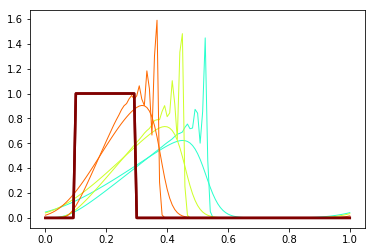

In [277]:
X = Main(121,601,0.5,1,0.001,"picard",0)
Plotting(X,121,601)
### upwinding is equivalent to adding diffusion, ie increasing to 0.01###
X = Main(121,601,0.5,1,0.01,"picard",0) 
Plotting(X,121,601)
### doesnt capture interface, but is nice and smooth with no oscilations###
### as predicted


theta= 0.5


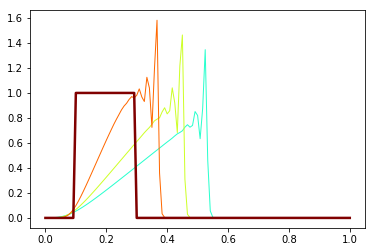

In [278]:
X = Main(121,601,0.5,1,0.001,"newton",0.5)
Plotting(X,121,601)

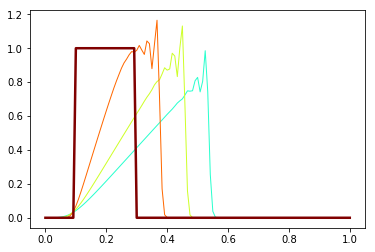

In [279]:
X = Main(121,601,0.5,1,0.001,"lax_picard",0)
Plotting(X,121,601)

theta= 0.5


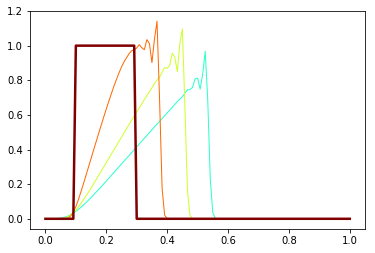

In [280]:
X = Main(121,601,0.5,1,0.001,"lax_newton",0.5)
Plotting(X,121,601)

In [281]:
## to do list:
##• for mu to 0 we get the oscilations associated with cs and lax performs better
#•Create a way of outputting error messages, 
#•Stability analysis for theta = 0 cases remembering whether vonn neuman annalisis works

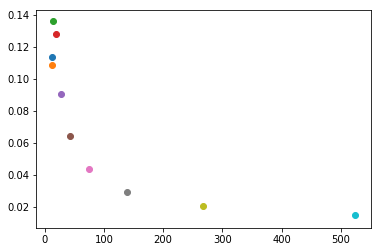

In [286]:
#analysis for increasing spatial resolution at a further timestep
for w in range(10):
    nx = 2**w+11
    nt = 601
    AA = Main(nx,nt,0.5,1,0.001,"picard",0)
    vec = AA[nt-1,:]
    yy = np.linalg.norm(vec,2)/nx
    plt.scatter(nx,yy)
    
### can i see quadratic convergence in space up until gibbslike 
###phenomena dominate? ###

### REAL PROBLEM ###
### higher spatial discretisation increases cost of implicit methods
### so explicit may actually be the way to go... 

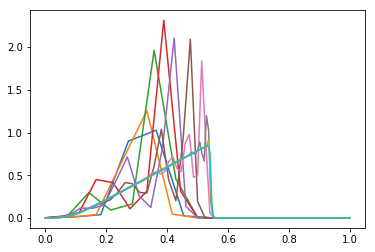

In [287]:
for w in range(10):
    nx = 2**w+11
    x = np.linspace(0,1,nx)
    nt = 601
    AA = Main(nx,nt,0.5,1,0.001,"picard",0)
    vec = AA[nt-1,:]
    plt.plot(x,vec)
    
### We have the effect of spatial discretisation on the final time-step